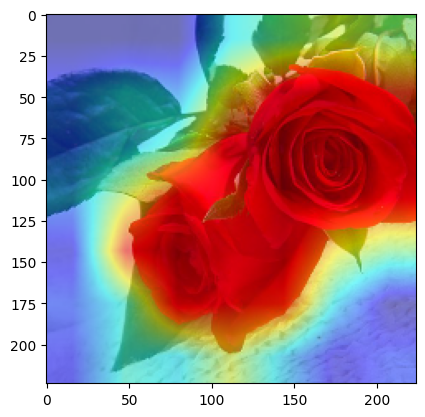

In [32]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
# 需选择要使用的模型
# from swin_model import swin_base_patch4_window7_224_in22k
# from model import swin_tiny_patch4_window7_224, swin_small_patch4_window7_224, swin_base_patch4_window7_224, swin_base_patch4_window12_384, swin_tiny_patch4_window7_224_22kto1k_finetune, swin_small_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_large_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_base_patch4_window7_224_in22k, swin_base_patch4_window12_384_in22k, swin_large_patch4_window7_224_in22k, swin_large_patch4_window12_384_in22k
from model import swin_tiny_patch4_window7_224
from model import swin_small_patch4_window7_224
from model import swin_base_patch4_window7_224
from model import swin_base_patch4_window12_384
from model import swin_tiny_patch4_window7_224_22kto1k_finetune
from model import swin_small_patch4_window7_224_22kto1k_finetune
from model import swin_base_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window12_384_22kto1k_finetune 
from model import swin_base_patch4_window7_224_in22k 
from model import swin_base_patch4_window12_384_in22k 
from model import swin_large_patch4_window7_224_in22k 
from model import swin_large_patch4_window12_384_in22k 

MODEL_DICT = {
    "0": swin_tiny_patch4_window7_224,
    "1": swin_small_patch4_window7_224,
    "2": swin_base_patch4_window7_224,
    "3": swin_base_patch4_window12_384,
    "4": swin_tiny_patch4_window7_224_22kto1k_finetune,
    "5": swin_small_patch4_window7_224_22kto1k_finetune,
    "6": swin_base_patch4_window7_224_22kto1k_finetune,
    "7": swin_base_patch4_window12_384_22kto1k_finetune,
    "8": swin_large_patch4_window7_224_22kto1k_finetune,
    "9": swin_base_patch4_window12_384_22kto1k_finetune,
    "10": swin_large_patch4_window12_384_22kto1k_finetune,
    "11": swin_base_patch4_window7_224_in22k,
    "12": swin_base_patch4_window12_384_in22k,
    "13": swin_large_patch4_window7_224_in22k,
    "14": swin_large_patch4_window12_384_in22k,
}

# from model import swin_base_patch4_window7_224 as create_model


class ResizeTransform:
    def __init__(self, im_h: int, im_w: int):
        self.height = self.feature_size(im_h)
        self.width = self.feature_size(im_w)

    @staticmethod
    def feature_size(s):
        s = math.ceil(s / 4)  # PatchEmbed
        s = math.ceil(s / 2)  # PatchMerging1
        s = math.ceil(s / 2)  # PatchMerging2
        s = math.ceil(s / 2)  # PatchMerging3
        return s

    def __call__(self, x):
        result = x.reshape(x.size(0),
                           self.height,
                           self.width,
                           x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)

        return result


def main():
    # 注意输入的图片必须是32的整数倍
    # 否则由于padding的原因会出现注意力飘逸的问题
    img_size = 224
    # img_size = 384
    assert img_size % 32 == 0

    # 选择要使用的模型
#     model = swin_tiny_patch4_window7_224(num_classes=5)
    model = MODEL_DICT["0"](num_classes=5)
    # https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224.pth
    
    # 模型的路径
    weights_path = "./weights/swin_tiny_patch4_window7_224.pth"

    # 加载权重到cpu
    model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)

    target_layers = [model.norm]

    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    # img_path = "./Swin_CAM_photo/both.png"
    img_path = "./Swin_CAM_photo/rose1.jpg"
#     img_path = "./Swin_CAM_photo/tulips1.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, img_size)

    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False,
                  reshape_transform=ResizeTransform(im_h=img_size, im_w=img_size))
    # target_category = 281  # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
#     target_category = 0     #daisy
    # target_category = 1     #dandelion
    target_category = 2     #roses
#     target_category = 3     #sunflowers
#     target_category = 4     #tulips

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()


if __name__ == '__main__':
    main()


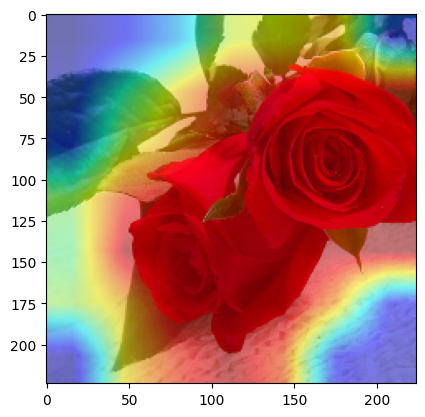

In [33]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
# 需选择要使用的模型
# from swin_model import swin_base_patch4_window7_224_in22k
# from model import swin_tiny_patch4_window7_224, swin_small_patch4_window7_224, swin_base_patch4_window7_224, swin_base_patch4_window12_384, swin_tiny_patch4_window7_224_22kto1k_finetune, swin_small_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_large_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_base_patch4_window7_224_in22k, swin_base_patch4_window12_384_in22k, swin_large_patch4_window7_224_in22k, swin_large_patch4_window12_384_in22k
from model import swin_tiny_patch4_window7_224
from model import swin_small_patch4_window7_224
from model import swin_base_patch4_window7_224
from model import swin_base_patch4_window12_384
from model import swin_tiny_patch4_window7_224_22kto1k_finetune
from model import swin_small_patch4_window7_224_22kto1k_finetune
from model import swin_base_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window12_384_22kto1k_finetune 
from model import swin_base_patch4_window7_224_in22k 
from model import swin_base_patch4_window12_384_in22k 
from model import swin_large_patch4_window7_224_in22k 
from model import swin_large_patch4_window12_384_in22k 

MODEL_DICT = {
    "0": swin_tiny_patch4_window7_224,
    "1": swin_small_patch4_window7_224,
    "2": swin_base_patch4_window7_224,
    "3": swin_base_patch4_window12_384,
    "4": swin_tiny_patch4_window7_224_22kto1k_finetune,
    "5": swin_small_patch4_window7_224_22kto1k_finetune,
    "6": swin_base_patch4_window7_224_22kto1k_finetune,
    "7": swin_base_patch4_window12_384_22kto1k_finetune,
    "8": swin_large_patch4_window7_224_22kto1k_finetune,
    "9": swin_base_patch4_window12_384_22kto1k_finetune,
    "10": swin_large_patch4_window12_384_22kto1k_finetune,
    "11": swin_base_patch4_window7_224_in22k,
    "12": swin_base_patch4_window12_384_in22k,
    "13": swin_large_patch4_window7_224_in22k,
    "14": swin_large_patch4_window12_384_in22k,
}

# from model import swin_base_patch4_window7_224 as create_model


class ResizeTransform:
    def __init__(self, im_h: int, im_w: int):
        self.height = self.feature_size(im_h)
        self.width = self.feature_size(im_w)

    @staticmethod
    def feature_size(s):
        s = math.ceil(s / 4)  # PatchEmbed
        s = math.ceil(s / 2)  # PatchMerging1
        s = math.ceil(s / 2)  # PatchMerging2
        s = math.ceil(s / 2)  # PatchMerging3
        return s

    def __call__(self, x):
        result = x.reshape(x.size(0),
                           self.height,
                           self.width,
                           x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)

        return result


def main():
    # 注意输入的图片必须是32的整数倍
    # 否则由于padding的原因会出现注意力飘逸的问题
    img_size = 224
    # img_size = 384
    assert img_size % 32 == 0

    # 选择要使用的模型
#     model = swin_tiny_patch4_window7_224(num_classes=5)
    model = MODEL_DICT["1"](num_classes=5)
    # https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224.pth
    
    # 模型的路径
    weights_path = "./weights/swin_small_patch4_window7_224.pth"

    # 加载权重到cpu
    model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)

    target_layers = [model.norm]

    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    # img_path = "./Swin_CAM_photo/both.png"
    img_path = "./Swin_CAM_photo/rose1.jpg"
#     img_path = "./Swin_CAM_photo/tulips1.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, img_size)

    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False,
                  reshape_transform=ResizeTransform(im_h=img_size, im_w=img_size))
    # target_category = 281  # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
#     target_category = 0     #daisy
    # target_category = 1     #dandelion
    target_category = 2     #roses
#     target_category = 3     #sunflowers
#     target_category = 4     #tulips

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()


if __name__ == '__main__':
    main()


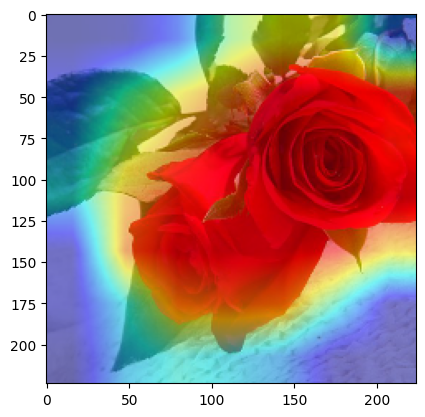

In [34]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
# 需选择要使用的模型
# from swin_model import swin_base_patch4_window7_224_in22k
# from model import swin_tiny_patch4_window7_224, swin_small_patch4_window7_224, swin_base_patch4_window7_224, swin_base_patch4_window12_384, swin_tiny_patch4_window7_224_22kto1k_finetune, swin_small_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_large_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_base_patch4_window7_224_in22k, swin_base_patch4_window12_384_in22k, swin_large_patch4_window7_224_in22k, swin_large_patch4_window12_384_in22k
from model import swin_tiny_patch4_window7_224
from model import swin_small_patch4_window7_224
from model import swin_base_patch4_window7_224
from model import swin_base_patch4_window12_384
from model import swin_tiny_patch4_window7_224_22kto1k_finetune
from model import swin_small_patch4_window7_224_22kto1k_finetune
from model import swin_base_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window12_384_22kto1k_finetune 
from model import swin_base_patch4_window7_224_in22k 
from model import swin_base_patch4_window12_384_in22k 
from model import swin_large_patch4_window7_224_in22k 
from model import swin_large_patch4_window12_384_in22k 

MODEL_DICT = {
    "0": swin_tiny_patch4_window7_224,
    "1": swin_small_patch4_window7_224,
    "2": swin_base_patch4_window7_224,
    "3": swin_base_patch4_window12_384,
    "4": swin_tiny_patch4_window7_224_22kto1k_finetune,
    "5": swin_small_patch4_window7_224_22kto1k_finetune,
    "6": swin_base_patch4_window7_224_22kto1k_finetune,
    "7": swin_base_patch4_window12_384_22kto1k_finetune,
    "8": swin_large_patch4_window7_224_22kto1k_finetune,
    "9": swin_base_patch4_window12_384_22kto1k_finetune,
    "10": swin_large_patch4_window12_384_22kto1k_finetune,
    "11": swin_base_patch4_window7_224_in22k,
    "12": swin_base_patch4_window12_384_in22k,
    "13": swin_large_patch4_window7_224_in22k,
    "14": swin_large_patch4_window12_384_in22k,
}

# from model import swin_base_patch4_window7_224 as create_model


class ResizeTransform:
    def __init__(self, im_h: int, im_w: int):
        self.height = self.feature_size(im_h)
        self.width = self.feature_size(im_w)

    @staticmethod
    def feature_size(s):
        s = math.ceil(s / 4)  # PatchEmbed
        s = math.ceil(s / 2)  # PatchMerging1
        s = math.ceil(s / 2)  # PatchMerging2
        s = math.ceil(s / 2)  # PatchMerging3
        return s

    def __call__(self, x):
        result = x.reshape(x.size(0),
                           self.height,
                           self.width,
                           x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)

        return result


def main():
    # 注意输入的图片必须是32的整数倍
    # 否则由于padding的原因会出现注意力飘逸的问题
    img_size = 224
    # img_size = 384
    assert img_size % 32 == 0

    # 选择要使用的模型
#     model = swin_tiny_patch4_window7_224(num_classes=5)
    model = MODEL_DICT["2"](num_classes=5)
    # https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224.pth
    
    # 模型的路径
    weights_path = "./weights/swin_base_patch4_window7_224.pth"

    # 加载权重到cpu
    model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)

    target_layers = [model.norm]

    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    # img_path = "./Swin_CAM_photo/both.png"
    img_path = "./Swin_CAM_photo/rose1.jpg"
#     img_path = "./Swin_CAM_photo/tulips1.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, img_size)

    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False,
                  reshape_transform=ResizeTransform(im_h=img_size, im_w=img_size))
    # target_category = 281  # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
#     target_category = 0     #daisy
    # target_category = 1     #dandelion
    target_category = 2     #roses
#     target_category = 3     #sunflowers
#     target_category = 4     #tulips

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()


if __name__ == '__main__':
    main()


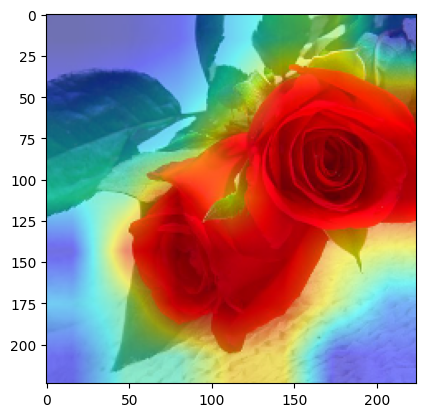

In [35]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
# 需选择要使用的模型
# from swin_model import swin_base_patch4_window7_224_in22k
# from model import swin_tiny_patch4_window7_224, swin_small_patch4_window7_224, swin_base_patch4_window7_224, swin_base_patch4_window12_384, swin_tiny_patch4_window7_224_22kto1k_finetune, swin_small_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_large_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_base_patch4_window7_224_in22k, swin_base_patch4_window12_384_in22k, swin_large_patch4_window7_224_in22k, swin_large_patch4_window12_384_in22k
from model import swin_tiny_patch4_window7_224
from model import swin_small_patch4_window7_224
from model import swin_base_patch4_window7_224
from model import swin_base_patch4_window12_384
from model import swin_tiny_patch4_window7_224_22kto1k_finetune
from model import swin_small_patch4_window7_224_22kto1k_finetune
from model import swin_base_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window12_384_22kto1k_finetune 
from model import swin_base_patch4_window7_224_in22k 
from model import swin_base_patch4_window12_384_in22k 
from model import swin_large_patch4_window7_224_in22k 
from model import swin_large_patch4_window12_384_in22k 

MODEL_DICT = {
    "0": swin_tiny_patch4_window7_224,
    "1": swin_small_patch4_window7_224,
    "2": swin_base_patch4_window7_224,
    "3": swin_base_patch4_window12_384,
    "4": swin_tiny_patch4_window7_224_22kto1k_finetune,
    "5": swin_small_patch4_window7_224_22kto1k_finetune,
    "6": swin_base_patch4_window7_224_22kto1k_finetune,
    "7": swin_base_patch4_window12_384_22kto1k_finetune,
    "8": swin_large_patch4_window7_224_22kto1k_finetune,
    "9": swin_base_patch4_window12_384_22kto1k_finetune,
    "10": swin_large_patch4_window12_384_22kto1k_finetune,
    "11": swin_base_patch4_window7_224_in22k,
    "12": swin_base_patch4_window12_384_in22k,
    "13": swin_large_patch4_window7_224_in22k,
    "14": swin_large_patch4_window12_384_in22k,
}

# from model import swin_base_patch4_window7_224 as create_model


class ResizeTransform:
    def __init__(self, im_h: int, im_w: int):
        self.height = self.feature_size(im_h)
        self.width = self.feature_size(im_w)

    @staticmethod
    def feature_size(s):
        s = math.ceil(s / 4)  # PatchEmbed
        s = math.ceil(s / 2)  # PatchMerging1
        s = math.ceil(s / 2)  # PatchMerging2
        s = math.ceil(s / 2)  # PatchMerging3
        return s

    def __call__(self, x):
        result = x.reshape(x.size(0),
                           self.height,
                           self.width,
                           x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)

        return result


def main():
    # 注意输入的图片必须是32的整数倍
    # 否则由于padding的原因会出现注意力飘逸的问题
    img_size = 224
    # img_size = 384
    assert img_size % 32 == 0

    # 选择要使用的模型
#     model = swin_tiny_patch4_window7_224(num_classes=5)
    model = MODEL_DICT["4"](num_classes=5)
    # https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224.pth
    
    # 模型的路径
    weights_path = "./weights/swin_tiny_patch4_window7_224_22kto1k_finetune.pth"

    # 加载权重到cpu
    model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)

    target_layers = [model.norm]

    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    # img_path = "./Swin_CAM_photo/both.png"
    img_path = "./Swin_CAM_photo/rose1.jpg"
#     img_path = "./Swin_CAM_photo/tulips1.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, img_size)

    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False,
                  reshape_transform=ResizeTransform(im_h=img_size, im_w=img_size))
    # target_category = 281  # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
#     target_category = 0     #daisy
    # target_category = 1     #dandelion
    target_category = 2     #roses
#     target_category = 3     #sunflowers
#     target_category = 4     #tulips

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()


if __name__ == '__main__':
    main()


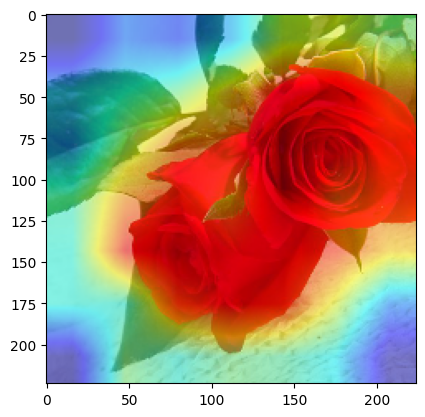

In [36]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
# 需选择要使用的模型
# from swin_model import swin_base_patch4_window7_224_in22k
# from model import swin_tiny_patch4_window7_224, swin_small_patch4_window7_224, swin_base_patch4_window7_224, swin_base_patch4_window12_384, swin_tiny_patch4_window7_224_22kto1k_finetune, swin_small_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_large_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_base_patch4_window7_224_in22k, swin_base_patch4_window12_384_in22k, swin_large_patch4_window7_224_in22k, swin_large_patch4_window12_384_in22k
from model import swin_tiny_patch4_window7_224
from model import swin_small_patch4_window7_224
from model import swin_base_patch4_window7_224
from model import swin_base_patch4_window12_384
from model import swin_tiny_patch4_window7_224_22kto1k_finetune
from model import swin_small_patch4_window7_224_22kto1k_finetune
from model import swin_base_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window12_384_22kto1k_finetune 
from model import swin_base_patch4_window7_224_in22k 
from model import swin_base_patch4_window12_384_in22k 
from model import swin_large_patch4_window7_224_in22k 
from model import swin_large_patch4_window12_384_in22k 

MODEL_DICT = {
    "0": swin_tiny_patch4_window7_224,
    "1": swin_small_patch4_window7_224,
    "2": swin_base_patch4_window7_224,
    "3": swin_base_patch4_window12_384,
    "4": swin_tiny_patch4_window7_224_22kto1k_finetune,
    "5": swin_small_patch4_window7_224_22kto1k_finetune,
    "6": swin_base_patch4_window7_224_22kto1k_finetune,
    "7": swin_base_patch4_window12_384_22kto1k_finetune,
    "8": swin_large_patch4_window7_224_22kto1k_finetune,
    "9": swin_base_patch4_window12_384_22kto1k_finetune,
    "10": swin_large_patch4_window12_384_22kto1k_finetune,
    "11": swin_base_patch4_window7_224_in22k,
    "12": swin_base_patch4_window12_384_in22k,
    "13": swin_large_patch4_window7_224_in22k,
    "14": swin_large_patch4_window12_384_in22k,
}

# from model import swin_base_patch4_window7_224 as create_model


class ResizeTransform:
    def __init__(self, im_h: int, im_w: int):
        self.height = self.feature_size(im_h)
        self.width = self.feature_size(im_w)

    @staticmethod
    def feature_size(s):
        s = math.ceil(s / 4)  # PatchEmbed
        s = math.ceil(s / 2)  # PatchMerging1
        s = math.ceil(s / 2)  # PatchMerging2
        s = math.ceil(s / 2)  # PatchMerging3
        return s

    def __call__(self, x):
        result = x.reshape(x.size(0),
                           self.height,
                           self.width,
                           x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)

        return result


def main():
    # 注意输入的图片必须是32的整数倍
    # 否则由于padding的原因会出现注意力飘逸的问题
    img_size = 224
    # img_size = 384
    assert img_size % 32 == 0

    # 选择要使用的模型
#     model = swin_tiny_patch4_window7_224(num_classes=5)
    model = MODEL_DICT["5"](num_classes=5)
    # https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224.pth
    
    # 模型的路径
    weights_path = "./weights/swin_small_patch4_window7_224_22kto1k_finetune.pth"

    # 加载权重到cpu
    model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)

    target_layers = [model.norm]

    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    # img_path = "./Swin_CAM_photo/both.png"
    img_path = "./Swin_CAM_photo/rose1.jpg"
#     img_path = "./Swin_CAM_photo/tulips1.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, img_size)

    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False,
                  reshape_transform=ResizeTransform(im_h=img_size, im_w=img_size))
    # target_category = 281  # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
#     target_category = 0     #daisy
    # target_category = 1     #dandelion
    target_category = 2     #roses
#     target_category = 3     #sunflowers
#     target_category = 4     #tulips

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()


if __name__ == '__main__':
    main()


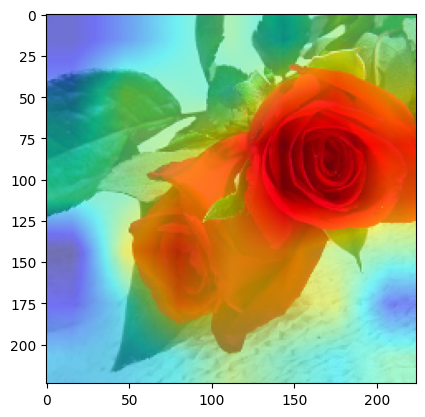

In [37]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img
# 需选择要使用的模型
# from swin_model import swin_base_patch4_window7_224_in22k
# from model import swin_tiny_patch4_window7_224, swin_small_patch4_window7_224, swin_base_patch4_window7_224, swin_base_patch4_window12_384, swin_tiny_patch4_window7_224_22kto1k_finetune, swin_small_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_large_patch4_window7_224_22kto1k_finetune, swin_base_patch4_window12_384_22kto1k_finetune, swin_base_patch4_window7_224_in22k, swin_base_patch4_window12_384_in22k, swin_large_patch4_window7_224_in22k, swin_large_patch4_window12_384_in22k
from model import swin_tiny_patch4_window7_224
from model import swin_small_patch4_window7_224
from model import swin_base_patch4_window7_224
from model import swin_base_patch4_window12_384
from model import swin_tiny_patch4_window7_224_22kto1k_finetune
from model import swin_small_patch4_window7_224_22kto1k_finetune
from model import swin_base_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window7_224_22kto1k_finetune 
from model import swin_base_patch4_window12_384_22kto1k_finetune 
from model import swin_large_patch4_window12_384_22kto1k_finetune 
from model import swin_base_patch4_window7_224_in22k 
from model import swin_base_patch4_window12_384_in22k 
from model import swin_large_patch4_window7_224_in22k 
from model import swin_large_patch4_window12_384_in22k 

MODEL_DICT = {
    "0": swin_tiny_patch4_window7_224,
    "1": swin_small_patch4_window7_224,
    "2": swin_base_patch4_window7_224,
    "3": swin_base_patch4_window12_384,
    "4": swin_tiny_patch4_window7_224_22kto1k_finetune,
    "5": swin_small_patch4_window7_224_22kto1k_finetune,
    "6": swin_base_patch4_window7_224_22kto1k_finetune,
    "7": swin_base_patch4_window12_384_22kto1k_finetune,
    "8": swin_large_patch4_window7_224_22kto1k_finetune,
    "9": swin_base_patch4_window12_384_22kto1k_finetune,
    "10": swin_large_patch4_window12_384_22kto1k_finetune,
    "11": swin_base_patch4_window7_224_in22k,
    "12": swin_base_patch4_window12_384_in22k,
    "13": swin_large_patch4_window7_224_in22k,
    "14": swin_large_patch4_window12_384_in22k,
}

# from model import swin_base_patch4_window7_224 as create_model


class ResizeTransform:
    def __init__(self, im_h: int, im_w: int):
        self.height = self.feature_size(im_h)
        self.width = self.feature_size(im_w)

    @staticmethod
    def feature_size(s):
        s = math.ceil(s / 4)  # PatchEmbed
        s = math.ceil(s / 2)  # PatchMerging1
        s = math.ceil(s / 2)  # PatchMerging2
        s = math.ceil(s / 2)  # PatchMerging3
        return s

    def __call__(self, x):
        result = x.reshape(x.size(0),
                           self.height,
                           self.width,
                           x.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        # [batch_size, H, W, C] -> [batch, C, H, W]
        result = result.permute(0, 3, 1, 2)

        return result


def main():
    # 注意输入的图片必须是32的整数倍
    # 否则由于padding的原因会出现注意力飘逸的问题
    img_size = 224
    # img_size = 384
    assert img_size % 32 == 0

    # 选择要使用的模型
#     model = swin_tiny_patch4_window7_224(num_classes=5)
    model = MODEL_DICT["9"](num_classes=5)
    # https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224.pth
    
    # 模型的路径
    weights_path = "./weights/swin_base_patch4_window12_384_22kto1k_finetune.pth"

    # 加载权重到cpu
    model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=False)

    target_layers = [model.norm]

    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # load image
    # img_path = "./Swin_CAM_photo/both.png"
    img_path = "./Swin_CAM_photo/rose1.jpg"
#     img_path = "./Swin_CAM_photo/tulips1.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, img_size)

    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False,
                  reshape_transform=ResizeTransform(im_h=img_size, im_w=img_size))
    # target_category = 281  # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
#     target_category = 0     #daisy
    # target_category = 1     #dandelion
    target_category = 2     #roses
#     target_category = 3     #sunflowers
#     target_category = 4     #tulips

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()


if __name__ == '__main__':
    main()
